&emsp;&emsp;&emsp;&emsp;**<font size=6 face="楷体">使用机器学习模型预测蜀宣花无角牛以及筛选相关突变位点</font>**

**<font size=5 face="宋体">(一)、读取与预处理</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">首先我们导入相应的数据处理包</font>**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as misn
%matplotlib inline

&ensp;&ensp;**<font color=red size=4 face="宋体">读取数据</font>**

In [2]:
data = pd.read_csv("polled_mutation.csv", encoding="GB2312")
data.head()

,Sample IDs,Horn,Month,Sex,P202ID,P80kbID,P219ID,P5ID,PG1855898A,PC1768587A,PG1654405A,D-loop
0,P1023,Polled,36,Female,W/M,W/W,W/W,W/W,G/G,C/C,G/G,B. taurus
1,P1170,Polled,6,Male,W/M,W/W,W/W,W/W,G/G,C/C,G/G,B. taurus
2,P1190,Polled,5,Male,W/M,W/W,W/W,W/W,G/G,C/C,G/G,B. indicus
3,P1025,Polled,60,Female,W/W,W/W,W/M,W/W,G/G,C/C,G/G,B. taurus
4,P1137,Polled,12,Female,W/M,W/W,W/W,W/W,G/G,C/C,G/G,B. taurus


&ensp;&ensp;**<font color=red size=4 face="宋体">分析特征类型</font>**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 12 columns):
Sample IDs    64 non-null object
Horn          64 non-null object
Month         64 non-null object
Sex           64 non-null object
P202ID        64 non-null object
P80kbID       64 non-null object
P219ID        64 non-null object
P5ID          64 non-null object
PG1855898A    64 non-null object
PC1768587A    64 non-null object
PG1654405A    64 non-null object
D-loop        64 non-null object
dtypes: object(12)
memory usage: 6.1+ KB


&ensp;&ensp;**<font size=3 face="宋体">可以看出每一列特征都为object属性，也就是类别属性</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">分析数据有无缺失</font>**

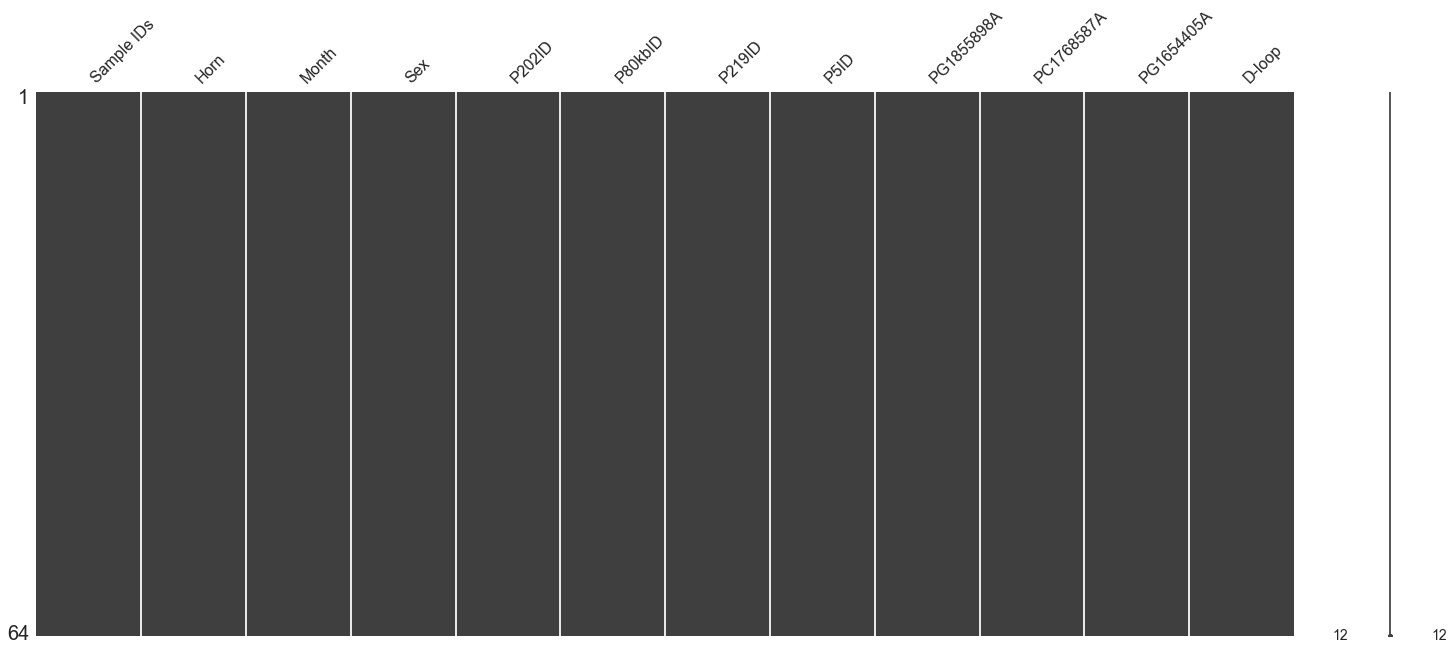

In [4]:
misn.matrix(data)

&ensp;&ensp;**<font size=3 face="宋体">数据完整，没有缺失</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">数据规模</font>**

In [5]:
sample,feature = data.shape
print("数据一共有%d个样本，%d种特征" % (sample, feature))

数据一共有64个样本，12种特征


&ensp;&ensp;**<font color=red size=4 face="宋体">去掉不相关特征</font>**

In [6]:
df = data.drop(["Sample IDs", "Month", "Sex", "D-loop"], axis=1)
df.head()

,Horn,P202ID,P80kbID,P219ID,P5ID,PG1855898A,PC1768587A,PG1654405A
0,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
1,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
2,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
3,Polled,W/W,W/W,W/M,W/W,G/G,C/C,G/G
4,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G


&ensp;&ensp;**<font color=red size=4 face="宋体">处理类别</font>**<br>

&ensp;&ensp;**<font size=3 face="宋体">无角性状是常染色体显性遗传，W/M和M/M突变都是无角，所以，我们将他们归为一类</font>**

In [7]:
df.nunique()

Horn          2
P202ID        3
P80kbID       2
P219ID        2
P5ID          2
PG1855898A    1
PC1768587A    2
PG1654405A    3
dtype: int64

In [8]:
df.loc[df["P202ID"] == "M/M", "P202ID"] = "W/M"
df.P202ID.unique()

array(['W/M', 'W/W'], dtype=object)

In [9]:
df.loc[df["PG1654405A"] == "A/A", "PG1654405A"] = "G/A"
df.PG1654405A.unique()

array(['G/G', 'G/A'], dtype=object)

In [10]:
df.nunique()

Horn          2
P202ID        2
P80kbID       2
P219ID        2
P5ID          2
PG1855898A    1
PC1768587A    2
PG1654405A    2
dtype: int64

&ensp;&ensp;**<font size=3 face="宋体">这样所有三类的特征都变成了两类</font>**

**<font size=5 face="宋体">(二)、构建模型预处理</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">还是先导入相应的机器学习包</font>**

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report


In [12]:
df.head()

,Horn,P202ID,P80kbID,P219ID,P5ID,PG1855898A,PC1768587A,PG1654405A
0,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
1,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
2,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
3,Polled,W/W,W/W,W/M,W/W,G/G,C/C,G/G
4,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G


&ensp;&ensp;**<font color=red size=4 face="宋体">LabelEncoder编码</font>**

In [13]:
categoricals = [x for x in df.columns if df[x].dtype == "object"]
for feat in categoricals:
    lab = LabelEncoder()
    lab.fit(list(df[feat].values))
    df[feat] = lab.transform(list(df[feat].values))
df.head()

,Horn,P202ID,P80kbID,P219ID,P5ID,PG1855898A,PC1768587A,PG1654405A
0,1,0,1,1,1,0,1,1
1,1,0,1,1,1,0,1,1
2,1,0,1,1,1,0,1,1
3,1,1,1,0,1,0,1,1
4,1,0,1,1,1,0,1,1


&ensp;&ensp;**<font size=3 face="宋体">这样就将类别型数据转化为了数值型数据</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">分割数据集</font>**<br>

&ensp;&ensp;**<font size=3 face="宋体">分离数据的特征和要预测的目标，再将整个数据集分为训练集和测试集</font>**

In [14]:
# 特征X
X = df.iloc[:, 1:]
# 预测类别y
y = df.iloc[:, 0]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

**<font size=5 face="宋体">(三)、构建逻辑回归模型</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">首先，我们使用缺省的逻辑回归预测</font>**

In [16]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

&ensp;&ensp;**<font color=red size=4 face="宋体">缺省的逻辑回归的准确性</font>**

In [17]:
score = LR.score(X_test, y_test)
print("缺省的逻辑回归模型在测试集上的性能得分为%.4f" % score)

缺省的逻辑回归模型在测试集上的性能得分为0.9231


&ensp;&ensp;**<font color=red size=4 face="宋体">缺省的逻辑回归的精度和召回率</font>**

In [18]:
prediction = LR.predict(X_test)
print(classification_report(y_test, prediction, target_names=["Horned", "Polled"]))

             precision    recall  f1-score   support

     Horned       0.67      1.00      0.80         2
     Polled       1.00      0.91      0.95        11

avg / total       0.95      0.92      0.93        13



&ensp;&ensp;**<font color=red size=4 face="宋体">使用ROC曲线检验模型性能</font>**

In [19]:
pred = LR.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, pred)
auc = auc(fpr, tpr)
print("逻辑回归模型的AUC值为%.4f" % auc)

逻辑回归模型的AUC值为0.9545


&ensp;&ensp;**<font color=red size=4 face="宋体">可视化ROC曲线</font>**

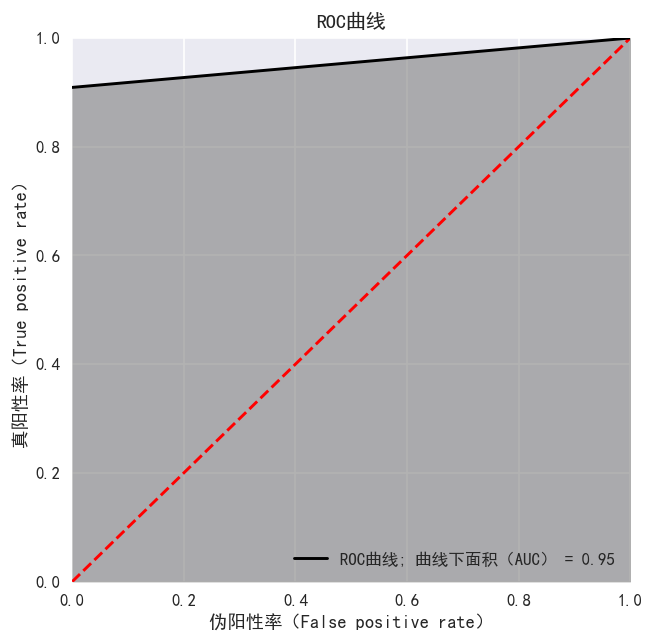

In [20]:
plt.rcParams["font.sans-serif"]=["SimHei"]
# 创建一个图形框
fig = plt.figure(figsize=(6, 6), dpi=120)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
# 在Matplotlib中显示中文，需要使用unicode
ax.set_title("%s" % u"ROC曲线")
ax.set_xlabel("伪阳性率（False positive rate）")
ax.set_ylabel("真阳性率（True positive rate）")
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, "k", label="%s; %s = %0.2f" % (u"ROC曲线",
        u"曲线下面积（AUC）", auc))
ax.fill_between(fpr, tpr, color="grey", alpha=0.6)
legend = plt.legend(shadow=True)
# plt.savefig("ROC.png")

&ensp;&ensp;**<font color=red size=4 face="宋体">然后，我们再通过gridsearchCV进行调参</font>**

In [21]:
#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print("最佳正则化类型：%s，\n最佳正则化系数：%d。" % (grid.best_params_["penalty"], grid.best_params_["C"]))

最佳正则化类型：l1，
最佳正则化系数：100。


&ensp;&ensp;**<font color=red size=4 face="宋体">得到最佳参数后，我再带入逻辑回归模型</font>**

In [23]:
model_1 = LogisticRegression(penalty="l1", C=10)
model_1.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

&ensp;&ensp;**<font color=red size=4 face="宋体">带参数的逻辑回归模型准确性</font>**

In [24]:
score = model_1.score(X_test, y_test)
print("带参数的逻辑回归模型在测试集上的性能得分为%.4f" % score)

带参数的逻辑回归模型在测试集上的性能得分为1.0000


&ensp;&ensp;**<font size=3 face="宋体">带参数的逻辑回归模型准确性比缺省的逻辑回归模型好一些，在测试集上已经达到了1。</font>**<br>

&ensp;&ensp;**<font size=3 face="宋体">我们除了可以调整参数使模型的性能增强，同时，也可以增加模型复杂度。下面我们就将增加模型的复杂度，从而增加模型的性能。</font>**<br>

**<font size=5 face="宋体">(四)、构建支持向量机模型</font>**

In [25]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib as mpl
from sklearn import metrics

In [26]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
score = svc.score(X_test, y_test)
print("缺省的支持向量机模型在测试集上的性能得分为%.4f" % score)

缺省的支持向量机模型在测试集上的性能得分为1.0000


&ensp;&ensp;**<font size=3 face="宋体">我们可以看出增加了模型的复杂度，性能也提升了。</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">可视化混淆矩阵</font>**

Text(49.9878,0.5,'真实值（True value）')

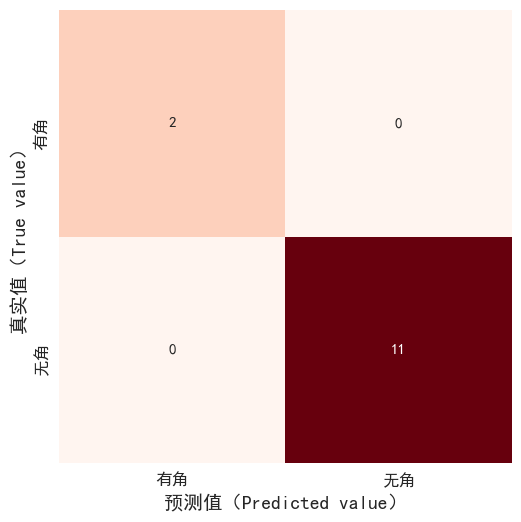

In [28]:
plt.rcParams["font.sans-serif"]=["SimHei"]
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.family'] = 'SimHei'

# 创建一个图形框
fig = plt.figure(figsize=(6, 6), dpi=100)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
y_predict = svc.predict(X_test)
met = metrics.confusion_matrix(y_test, y_predict)
sns.heatmap(met, square=True, annot=True, cbar=False, cmap="Reds", ax=ax, xticklabels=["有角", "无角"], yticklabels=["有角", "无角"])
plt.xlabel("预测值（Predicted value）")
plt.ylabel("真实值（True value）")

&ensp;&ensp;**<font color=red size=4 face="宋体">缺省的支持向量机模型的精度和召回率</font>**

In [29]:
print(classification_report(y_test, y_predict, target_names=["Horned", "Polled"]))

             precision    recall  f1-score   support

     Horned       1.00      1.00      1.00         2
     Polled       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        13



&ensp;&ensp;**<font color=red size=4 face="宋体">使用ROC曲线检验模型性能</font>**

In [30]:
pred = svc.predict(X_test).astype("float64")
fpr, tpr, _ = roc_curve(y_test, pred)
auc = metrics.auc(fpr, tpr)
auc

1.0

&ensp;&ensp;**<font color=red size=4 face="宋体">可视化ROC曲线</font>**

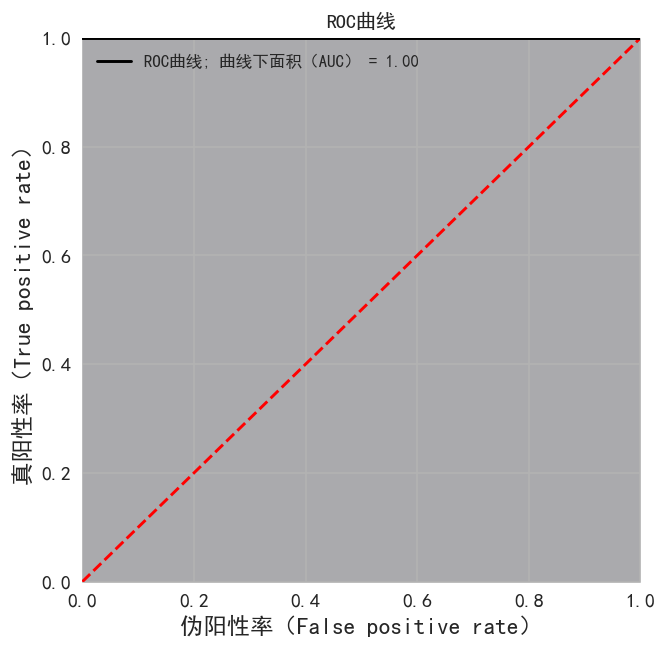

In [31]:
plt.rcParams["font.sans-serif"]=["SimHei"]
# 创建一个图形框
fig = plt.figure(figsize=(6, 6), dpi=120)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
# 在Matplotlib中显示中文，需要使用unicode
ax.set_title("%s" % u"ROC曲线")
ax.set_xlabel("伪阳性率（False positive rate）")
ax.set_ylabel("真阳性率（True positive rate）")
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, "k", label="%s; %s = %0.2f" % (u"ROC曲线",
        u"曲线下面积（AUC）", auc))
ax.fill_between(fpr, tpr, color="grey", alpha=0.6)
legend = plt.legend(shadow=True)
# plt.savefig("ROC.png")

**<font size=5 face="宋体">(五)、构建决策树模型选择特征</font>**

In [32]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

&ensp;&ensp;**<font color=red size=4 face="宋体">缺省的决策树模型的准确性</font>**

In [33]:
y_prob = model_tree.predict_proba(X_test)[:,1]
y_pred = np.where(y_prob > 0.5, 1, 0)
model_tree.score(X_test, y_pred)

1.0

&ensp;&ensp;**<font size=3 face="宋体">树模型可以直接使用类别型数据，做特征选择。</font>**<br>

&ensp;&ensp;**<font size=3 face="宋体">因此，我们在这里可以利用这点特征选择出真正与牛角性状相关联的突变</font>**

&ensp;&ensp;**<font color=red size=4 face="宋体">特征选择</font>**

In [34]:
data_ = data.drop(["Sample IDs", "Month", "Sex", "D-loop"], axis=1)
data_.loc[data_["P202ID"] == "M/M", "P202ID"] = "W/M"
data_.loc[data_["PG1654405A"] == "A/A", "PG1654405A"] = "G/A"
data_.head()

,Horn,P202ID,P80kbID,P219ID,P5ID,PG1855898A,PC1768587A,PG1654405A
0,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
1,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
2,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G
3,Polled,W/W,W/W,W/M,W/W,G/G,C/C,G/G
4,Polled,W/M,W/W,W/W,W/W,G/G,C/C,G/G


In [35]:
data_feature_name = data_.columns[1:]
data_target_name = np.unique(data_["Horn"])

In [36]:
model_tree_ = DecisionTreeClassifier()
model_tree_.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
X_train.columns

Index(['P202ID', 'P80kbID', 'P219ID', 'P5ID', 'PG1855898A', 'PC1768587A',
       'PG1654405A'],
      dtype='object')

In [38]:
impro = pd.DataFrame({"Feature": X_train.columns, "Importance": list(model_tree.feature_importances_.tolist())})

In [39]:
impro.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,P202ID,0.549242
2,P219ID,0.284091
1,P80kbID,0.166667
3,P5ID,0.000000
4,PG1855898A,0.000000
5,PC1768587A,0.000000
6,PG1654405A,0.000000


&ensp;&ensp;**<font color=red size=4 face="宋体">可视化树模型</font>**

In [40]:
import graphviz
import pydotplus
from sklearn import tree
from IPython.display import Image
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_tree = tree.export_graphviz(model_tree_,out_file=None,feature_names=data_feature_name,class_names=data_target_name,filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_tree)
img = Image(graph.create_png())
graph.write_png("result.png")

True

<img src="./result.png", width=320, heigth=240>

&ensp;&ensp;&ensp;&ensp;**<font size=3 face="宋体">最终，我们可以看到决策树选择了P202ID、P219ID和P80kbID这三个突变，恰好这三个突变正是决定牛角性状的候选突变位点。</font>**<br>

&ensp;&ensp;&ensp;&ensp;**<font size=3 face="宋体">因此，事实证明我们使用的机器学习模型也可以用于选择与性状相关联的突变位点或基因。使用这种方法我们会更加节约成本、提高效率，并且这也是未来基因或位点检测的主要研究方向</font>**